In [2]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import re

import networkx.algorithms.community as comms

In [3]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

In [4]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i] # adds 'p' to the People nodes to differentiate them

In [5]:
lasts = []
for n in name:
    lasts.append((re.findall('[A-Z][^A-Z]*', n))[0])

In [6]:
#Read in graph and find and isolate the greatest connected component

B = nx.read_edgelist(data)
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, name=name[j], last=lasts[j], sex=sex[j]) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role=role[i]) # why role is in a list?
    i+=1

p_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # people
c_nodes = set(G) - p_nodes # crimes

# components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
# selecting the biggest component
G0 = G.subgraph(Gcc[0])

P 754 2127


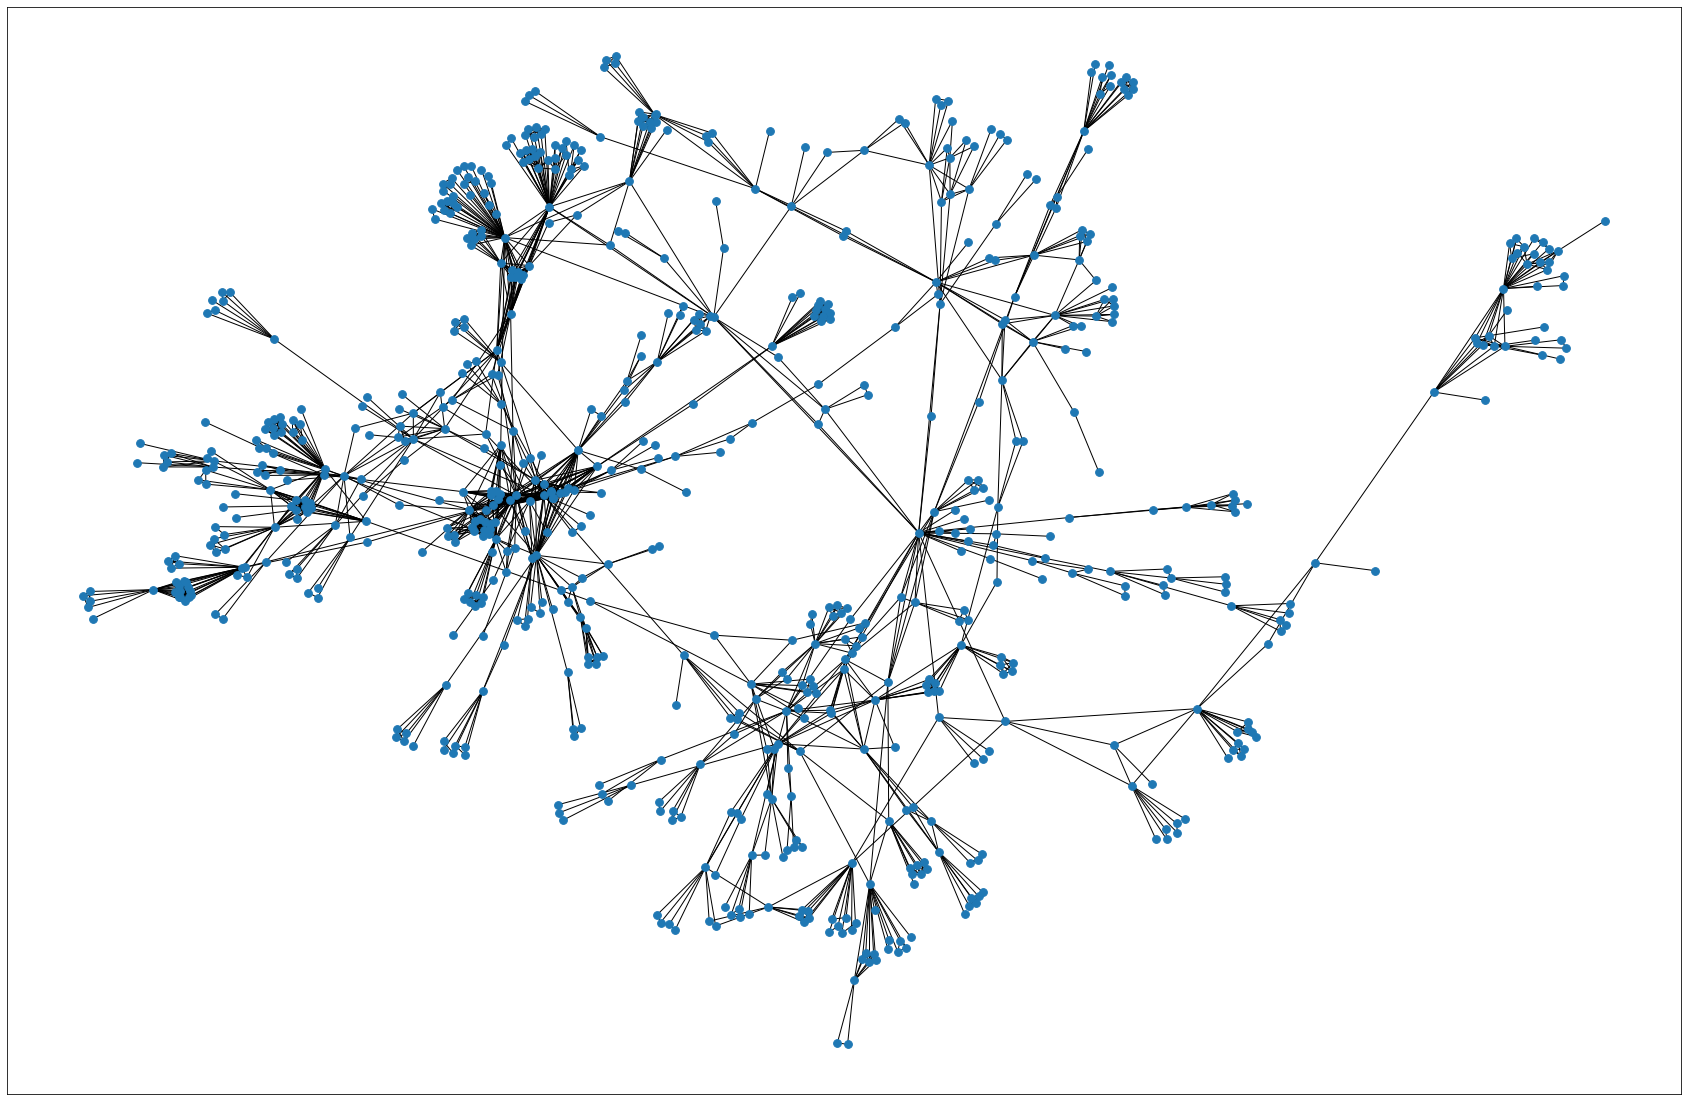

In [7]:
#Seperate the nodes for People and Crimes
p_nodes_gcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_gcc = set(G0) - p_nodes_gcc

#print(len(p_nodes_gcc), len(c_nodes_gcc))

# project onto people and visualise
P = bipartite.weighted_projected_graph(G0, p_nodes_gcc)

print('P',len(P.nodes()), len(P.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P, seed=23)

nx.draw_networkx(P, pos, node_size=60, with_labels=False)

In [8]:
bet_centrality = nx.betweenness_centrality(P, normalized = True, 
                                              endpoints = False)

In [9]:
#sorted(bet_centrality.values(), reverse=True)

max(bet_centrality.values())

0.42280023675629974

In [10]:
for k,v in bet_centrality.items():
    if v == max(bet_centrality.values()):
        print(k)
        POI = k

p815


In [11]:
#POI = 'p815' #set a Person of Interest if not using the highest betweeness centrality person

communities = sorted(comms.greedy_modularity_communities(P), key=len, reverse=True) #30 coms modularity 0.845
#communities = sorted(comms.label_propagation_communities(P), key=len, reverse=True) #89 coms modularity 0.787

# Count the communities
print(f"There are {len(communities)} communities.")

comms.modularity(P, communities)

for i in range(len(communities)):
    if POI in communities[i]:
        print(f'The POI is in community {i}')
        highlight = i #sets the POI's community to be highlighted in graphs below

There are 30 communities.
The POI is in community 2


0 122
1 84
2 57
3 55
4 55
5 45
6 34
7 32
8 30
9 30


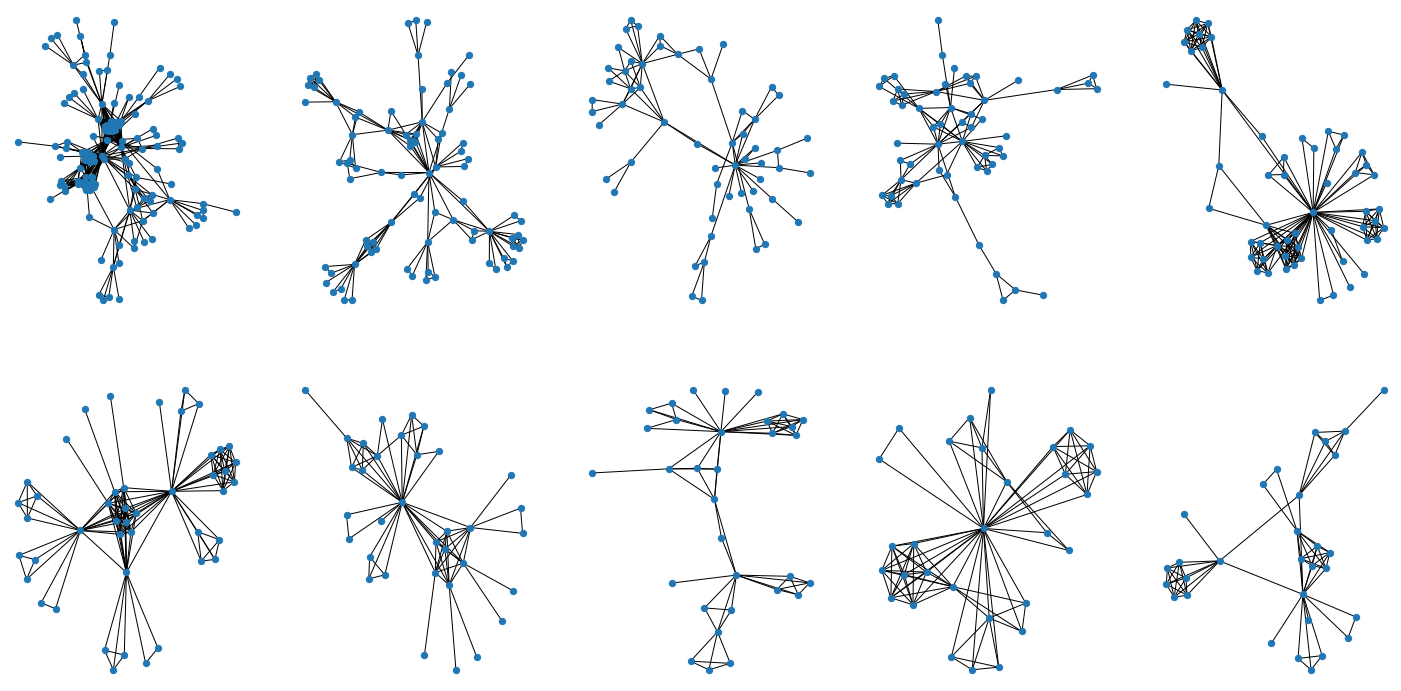

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,10): 
    com = P.subgraph(communities[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
plt.savefig(f'../Figures/1-10_community.jpg')

10 28
11 25
12 24
13 14
14 14
15 14
16 13
17 9
18 8
19 8


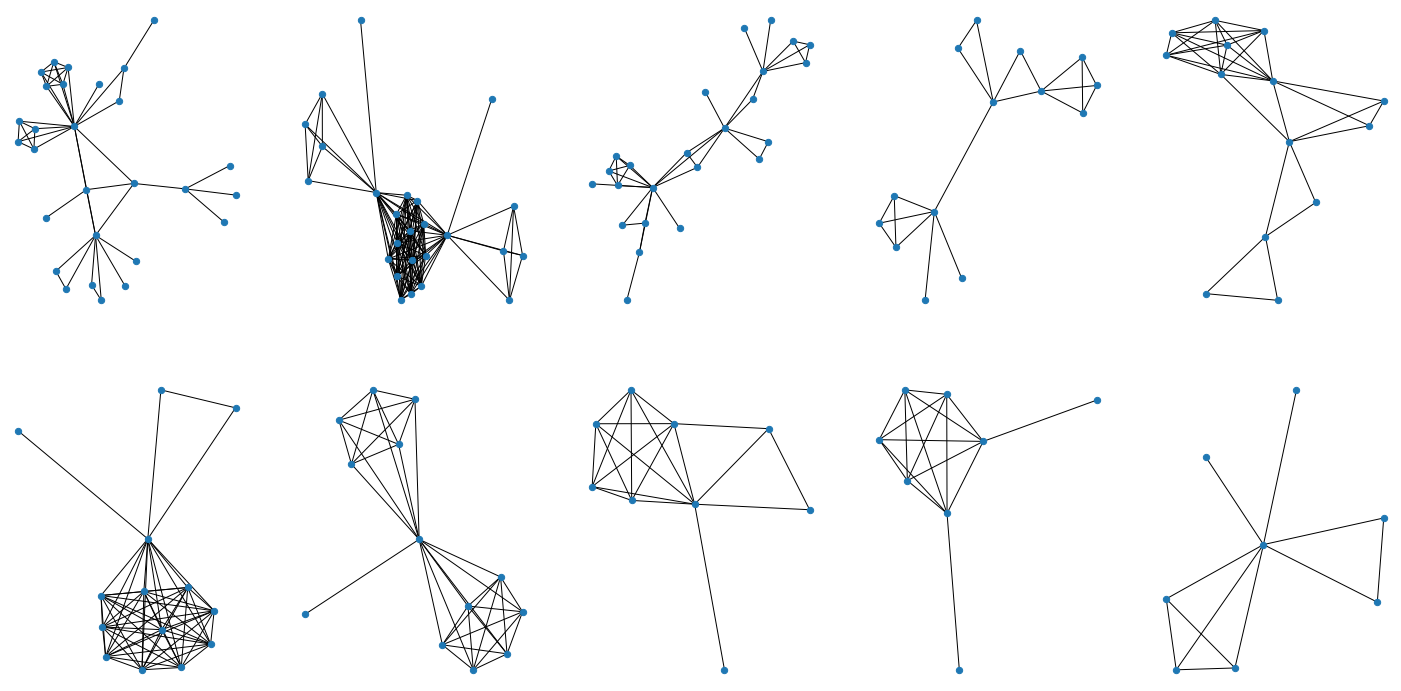

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(10,20): 
    com = P.subgraph(communities[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i-9)
    nx.draw_spring(com, node_size=40)
plt.savefig(f'../Figures/11-20_community.jpg')

20 7
21 7
22 7
23 6
24 6
25 5
26 4
27 4
28 4
29 3


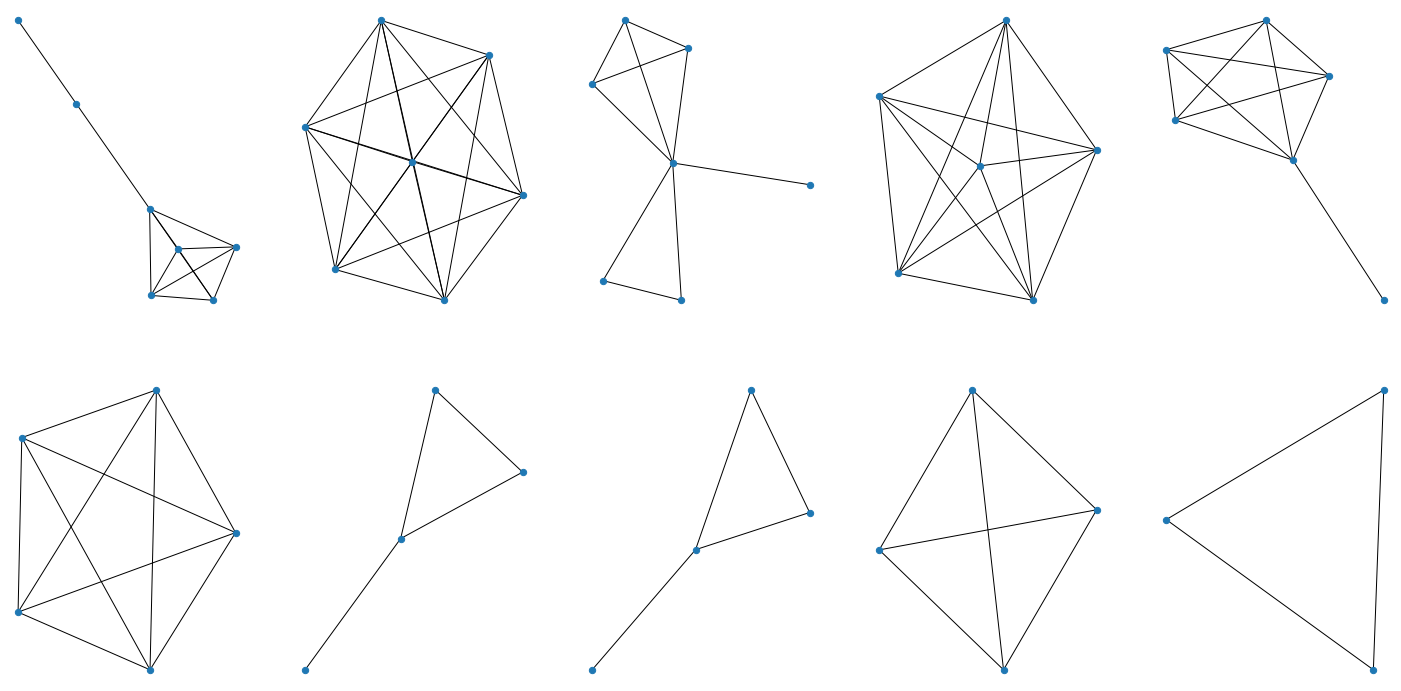

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(20,30): 
    com = P.subgraph(communities[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i-19)
    nx.draw_spring(com, node_size=40)
plt.savefig(f'../Figures/21-30_community.jpg')

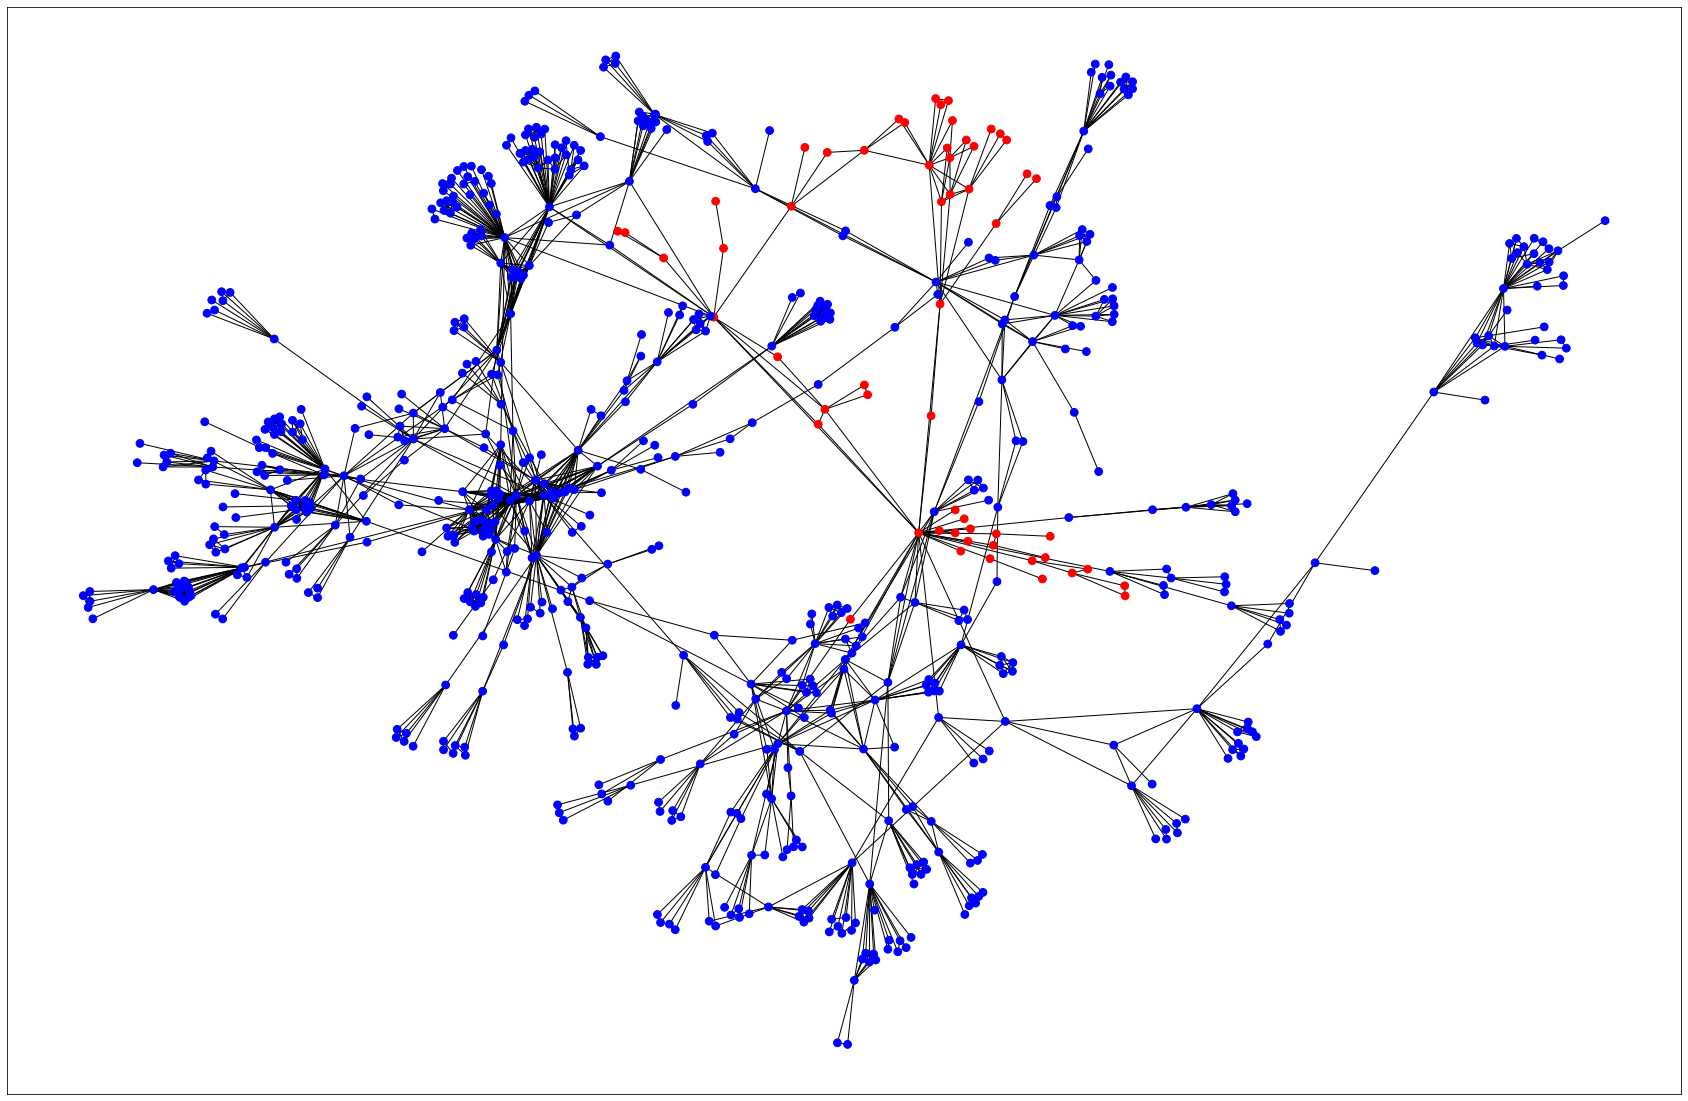

In [15]:
#highlight = 11 #choose a community to highlight via it's index in the communities list

node_col = []

for node in P.nodes():
    if node in communities[highlight]:
        node_col.append('red')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P, seed=23)

nx.draw_networkx(P, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_people_projection.jpg')

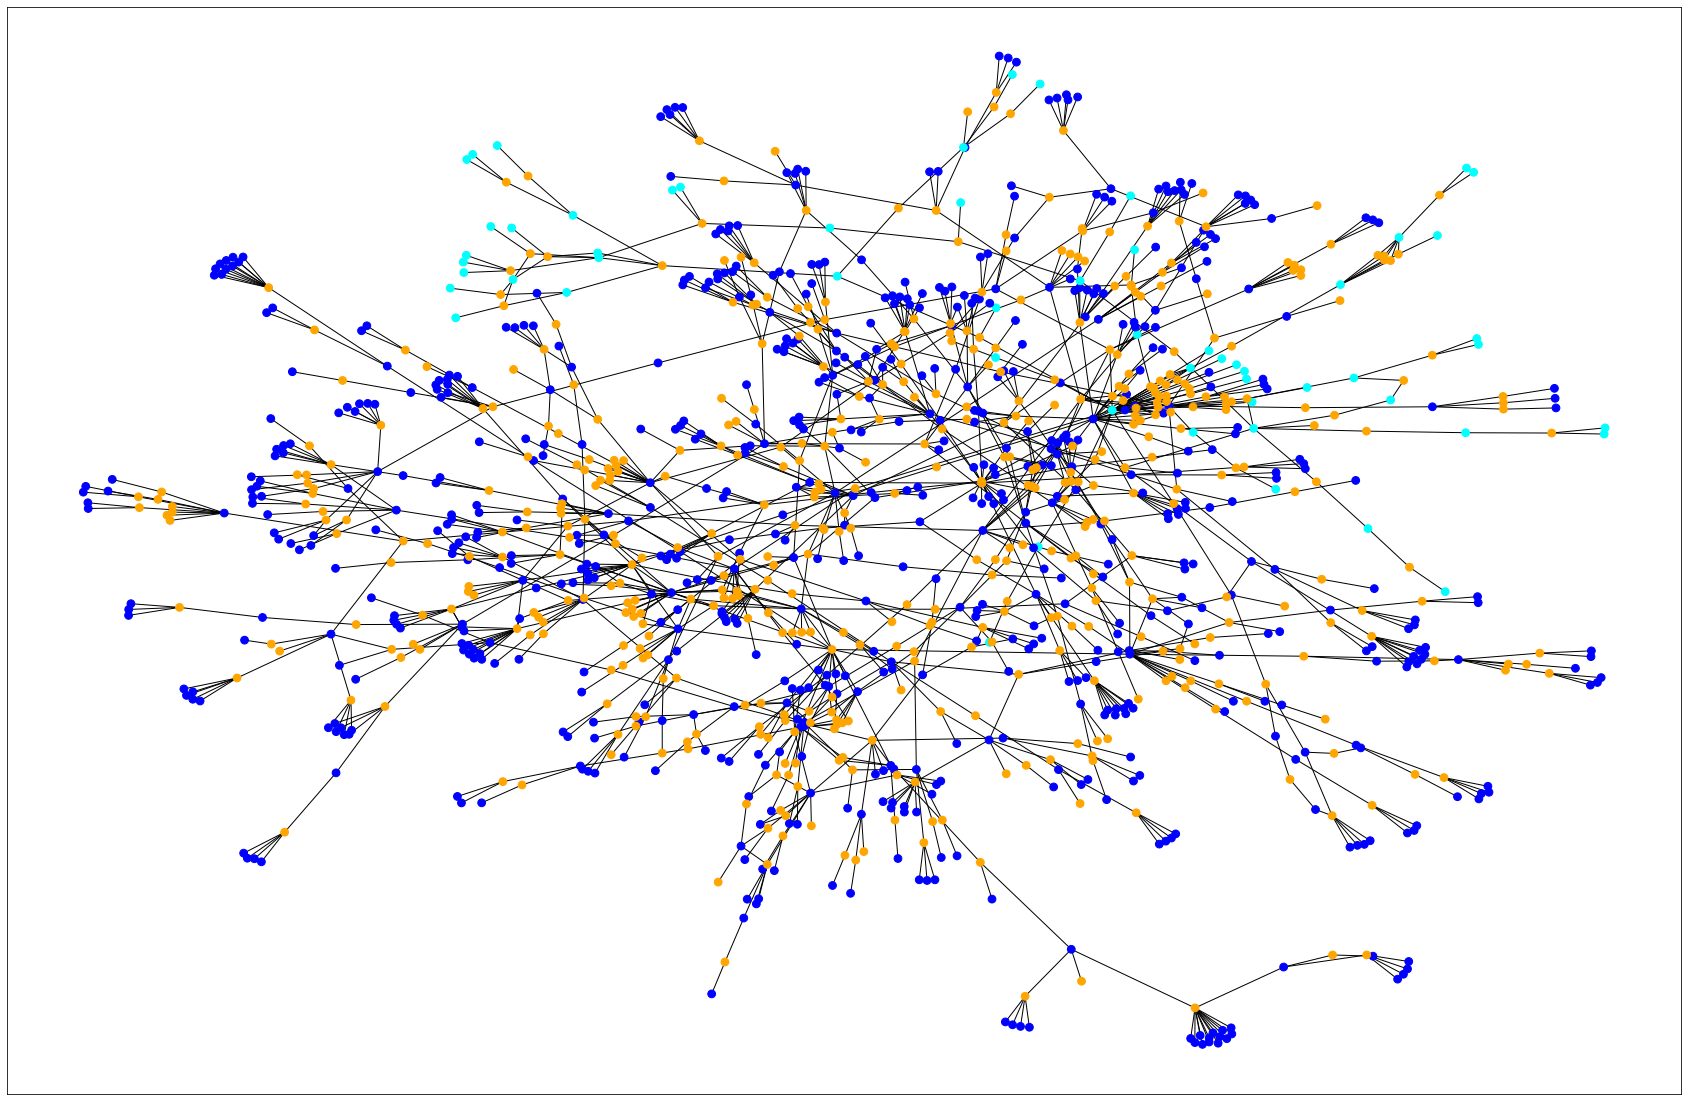

In [16]:
node_col = []

for node in G0.nodes():
    if node in communities[highlight]:
        node_col.append('aqua')
    elif node in c_nodes_gcc:
        node_col.append('orange')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_lcc_no projection.jpg')

In [17]:
ed = []
lab = {}

for per in communities[highlight]:
    print('\n------\n\n',nx.get_node_attributes(G, 'last')[per], nx.get_node_attributes(G, 'sex')[per])
    lab[per] = (nx.get_node_attributes(G, 'last')[per], per)
    for c in G.edges([per]):
        print(c, nx.get_edge_attributes(G0, 'role')[c])
        ed.append(c[1])
        lab[c[1]] = f'{c[1]}'


------

 Quincy 1
('p664', '358') Witness
('p664', '513') Suspect

------

 Quill 1
('p663', '400') Suspect
('p663', '511') Suspect
('p663', '512') Suspect

------

 Thomas 1
('p767', '130') Victim
('p767', '131') Victim
('p767', '132') Victim
('p767', '134') Witness
('p767', '135') Suspect
('p767', '494') Suspect

------

 Casey 0
('p231', '297') Suspect

------

 Angell 0
('p119', '184') Victim
('p119', '185') Victim

------

 Powell 0
('p650', '308') Victim

------

 Mobley 1
('p579', '242') Victim

------

 Andrews 0
('p118', '184') Witness

------

 Perkins 1
('p624', '503') Victim

------

 Hopkins 0
('p441', '185') Suspect
('p441', '433') Suspect

------

 Casper 0
('p232', '297') Victim

------

 Gregory 1
('p390', '396') Witness

------

 Browning 1
('p197', '254') Victim

------

 Stevenson 0
('p745', '514') Suspect

------

 Gumm 1
('p395', '400') Victim

------

 Sinclair 1
('p718', '494') Victim

------

 Jefferson 0
('p466', '54') Suspect
('p466', '242') Victim
('p466', 

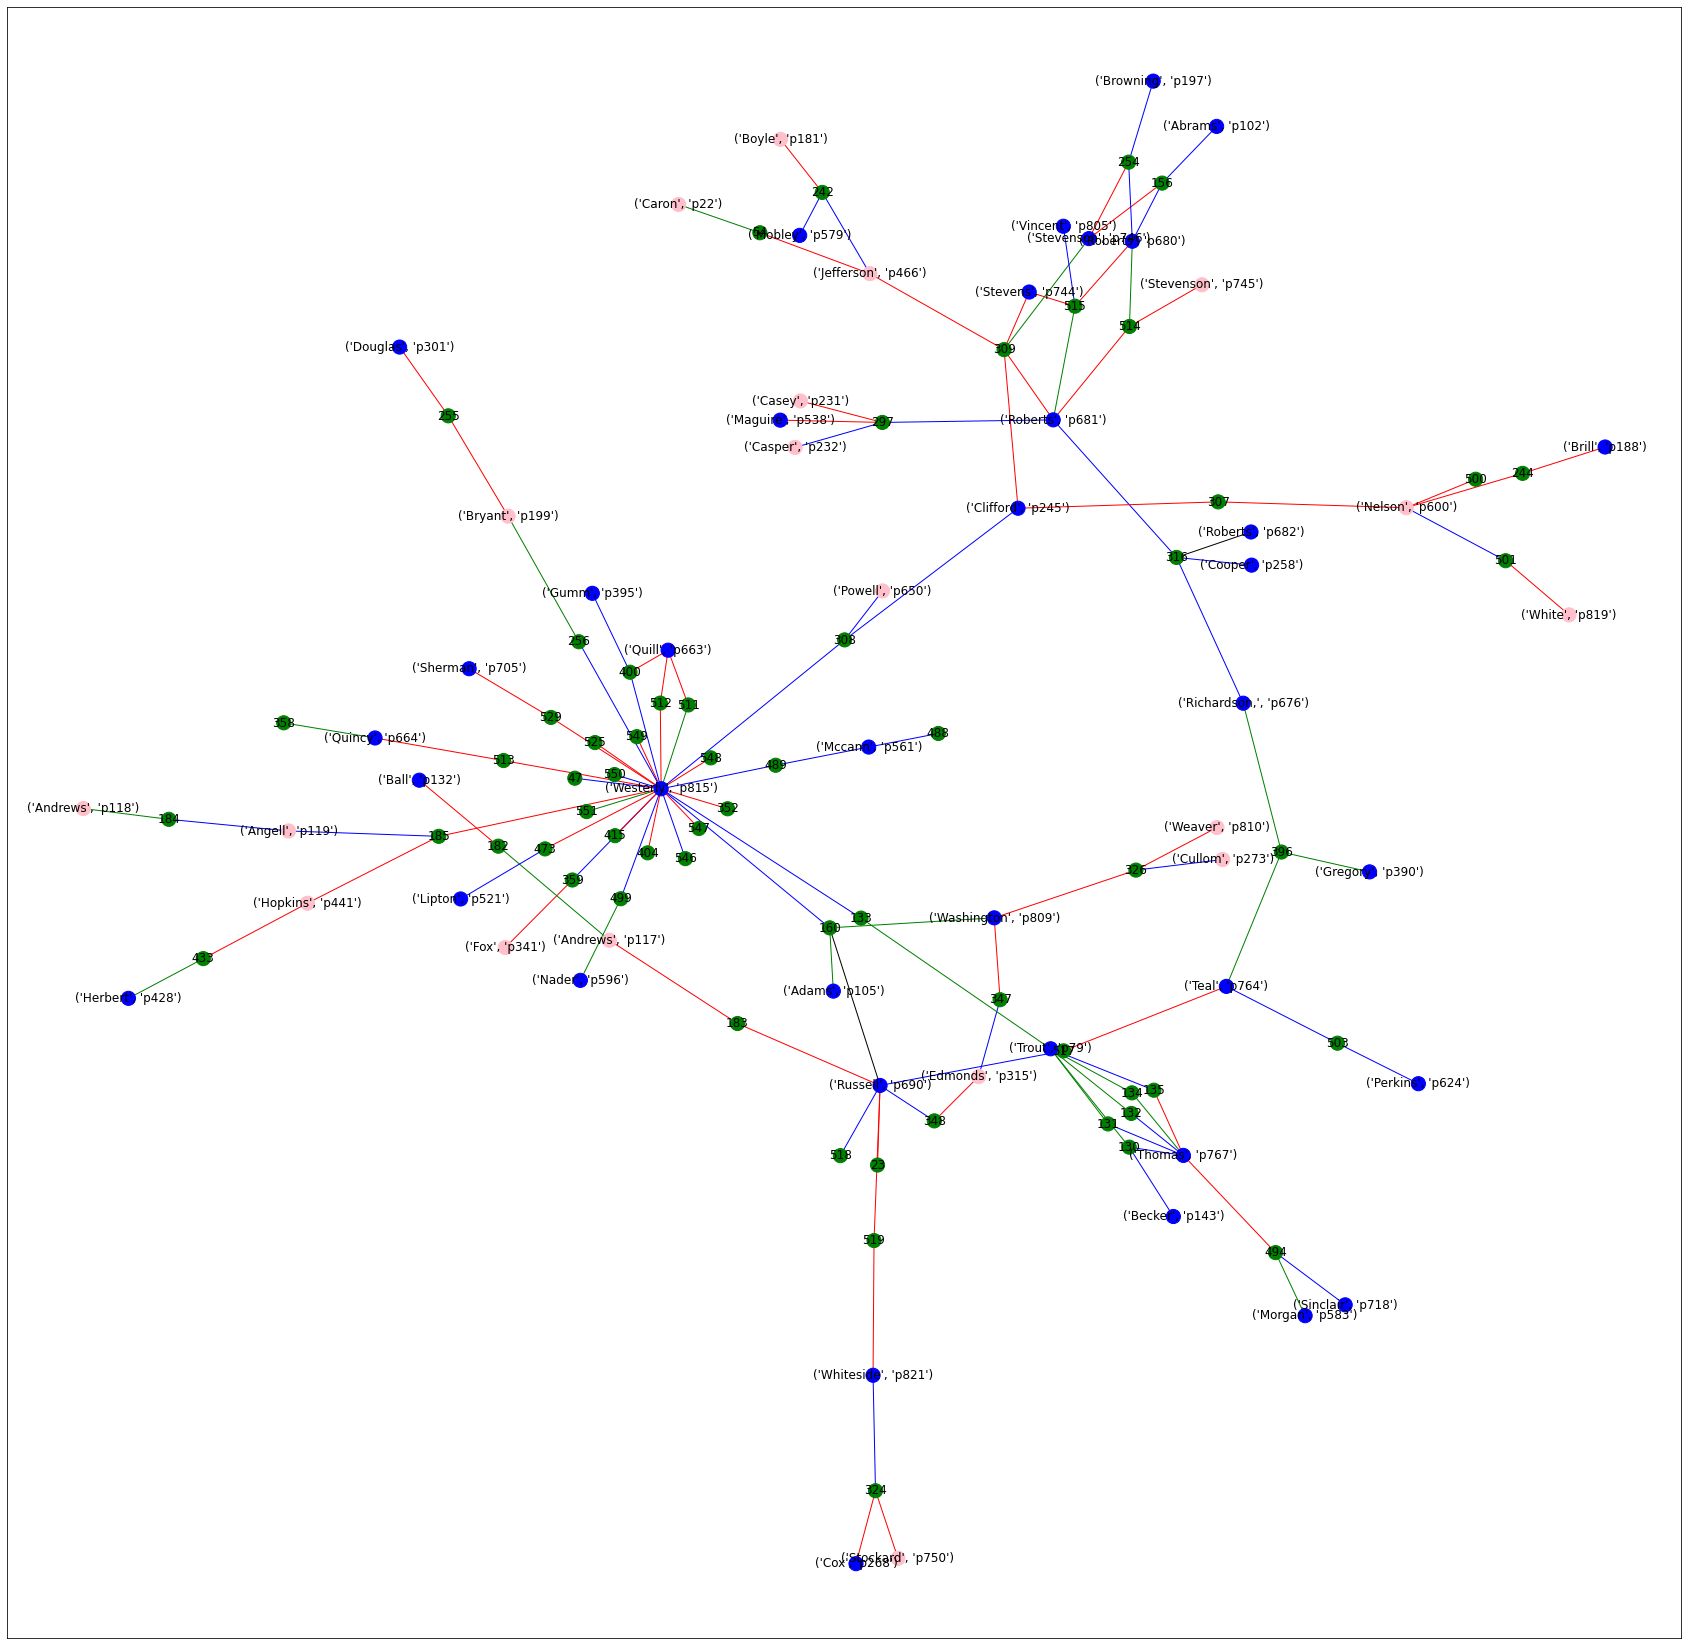

In [18]:
for i in communities[highlight]:
    ed.append(i)

nc = []
ec = []

hi = G0.subgraph(ed)

for node in hi:
    if node in communities[highlight]:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('blue')
        else:
            nc.append('pink')
    elif node in c_nodes_gcc:
        nc.append('green')
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
for edge in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[edge]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')        
        

plt.rcParams.update({'figure.figsize': (30, 30)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

plt.savefig(f'../Figures/community_{highlight}_focus_labelled.jpg')

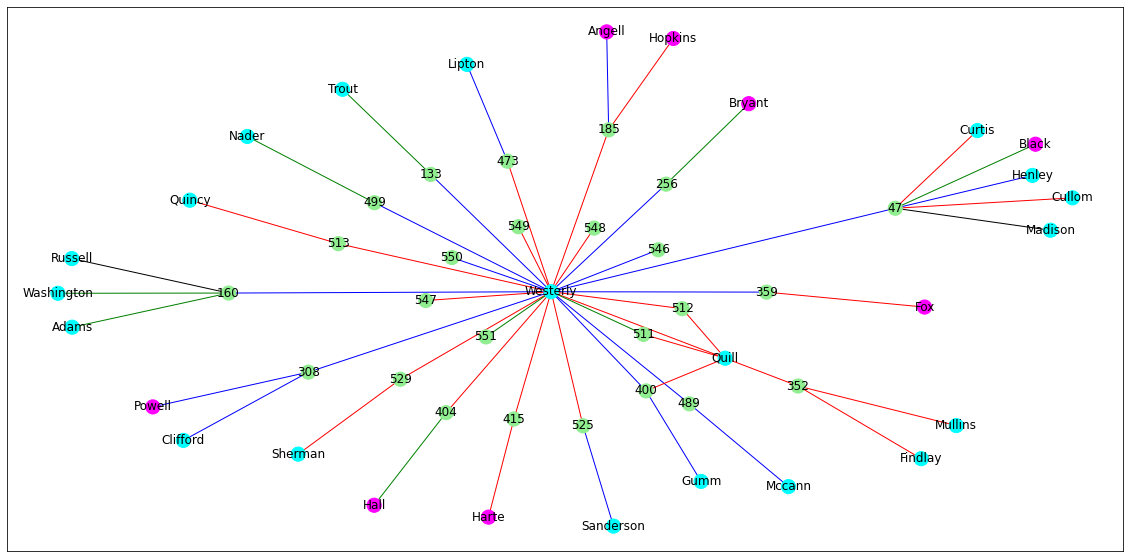

In [19]:
POI_G = nx.Graph()
POI_edges = []
nc = []
ec = []
lab = {}

for edge in G.edges():
    if POI in edge:
        POI_edges.append(edge)

for e in POI_edges:
    #print(e[1])
    POI_G.add_edges_from(G.edges(e[1]))

for node in POI_G:
    if node in p_nodes_gcc:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('aqua')
        else:
            nc.append('magenta')
        lab[node] = nx.get_node_attributes(G, 'last')[node]
    elif node in c_nodes_gcc:
        nc.append('lightgreen')
        lab[node] = node
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
    
        
for edge in POI_G.edges():
    try:
        a = nx.get_edge_attributes(G, 'role')[edge]
    except:
        a = nx.get_edge_attributes(G, 'role')[(edge[1], edge[0])]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')




        
plt.rcParams.update({'figure.figsize': (20, 10)})
pos = nx.spring_layout(POI_G, seed=13)

nx.draw_networkx(POI_G, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

In [20]:

for c in range(len(communities)):
    com_bet = []
    for per in communities[c]:
        com_bet.append(bet_centrality[per])
    
    print(c, max(com_bet))

0 0.18979209469528718
1 0.1477347282838265
2 0.42280023675629974
3 0.08542103241049334
4 0.22600957314641426
5 0.11323368589549777
6 0.08403266367155492
7 0.11899845626481798
8 0.14333701013396807
9 0.11022709961105481
10 0.1538729675686895
11 0.059570229719420185
12 0.05337553947970692
13 0.03416122743070272
14 0.006615971103764611
15 0.0314769291627815
16 0.08232947900209206
17 0.02105054957475064
18 0.007925743833177927
19 0.01586914752338165
20 0.011588535120932294
21 0.0
22 0.01586914752338165
23 0.0
24 0.013223700940917182
25 0.010581786329857873
26 0.007953999604419202
27 0.007953999604419202
28 0.007946935661608883
29 0.005305021050549574


## Now same again, but using crimes as projection.

In [ ]:
# project onto crimes and visualise
C = bipartite.weighted_projected_graph(G0, c_nodes_gcc)

print('C',len(C.nodes()), len(C.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(C, seed=23)

nx.draw_networkx(C, pos, node_size=60, with_labels=False)

In [ ]:
communities_c = sorted(comms.greedy_modularity_communities(C), key=len, reverse=True) #14 coms modularity 0.813
#communities_c = sorted(comms.label_propagation_communities(C), key=len, reverse=True) #50 coms modularity 0.763

# Count the communities
print(f"There are {len(communities_c)} communities.")

comms.modularity(C, communities_c)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,10): 
    com = C.subgraph(communities_c[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/1-10_C_community.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(10,14): 
    com = C.subgraph(communities_c[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i-9)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/11-14_C_community.jpg')

In [ ]:
COI = '415'
for i in range(len(communities_c)):
    if COI in communities_c[i]:
        print(i)
        highlight = i

highlight = 12 #choose a community to highlight via it's index in the communities list

node_col = []

for node in C.nodes():
    if node in communities_c[highlight]:
        node_col.append('red')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(C, seed=23)

nx.draw_networkx(C, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_crime_projection.jpg')

In [ ]:
node_col = []

for node in G0.nodes():
    if node in communities_c[highlight]:
        node_col.append('red')
    elif node in p_nodes_gcc:
        node_col.append('blue')
    else:
        node_col.append('green')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/c_community_{highlight}_lcc_no projection.jpg')

In [ ]:
lab = {}
no = []
ec = []
nc = []

for cri in communities_c[highlight]:
    no.append(cri)
    lab[cri] = f'{cri}'
    for edge in G0.edges(cri):
        no.append(edge[1])
    
no = set(no)       
for node in no:
    if node in c_nodes_gcc:
        nc.append('green')
        
    elif nx.get_node_attributes(G, 'sex')[node] == '1':
        nc.append('blue')
        lab[node] = (nx.get_node_attributes(G, 'last')[node], node)
    else:
        nc.append('pink')
        lab[node] = (nx.get_node_attributes(G, 'last')[node], node)

In [ ]:
hi = G0.subgraph(no)
ec = []

for c in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[c]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')

plt.rcParams.update({'figure.figsize': (15, 15)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, edge_color=ec, node_color = nc, labels=lab)

plt.savefig(f'../Figures/c_community_{highlight}_focus_labelled.jpg')

## Look at suspects only:

In [108]:
sus_edge = []
sus_nodes = []
for edge in G.edges():
    if nx.get_edge_attributes(G, 'role')[edge] == 'Suspect':
        sus_edge.append(edge)
        sus_nodes.append(edge[0])
       

len(set(sus_nodes)),len(sus_edge)

(464, 682)

844
36
Scc length 171
14 22


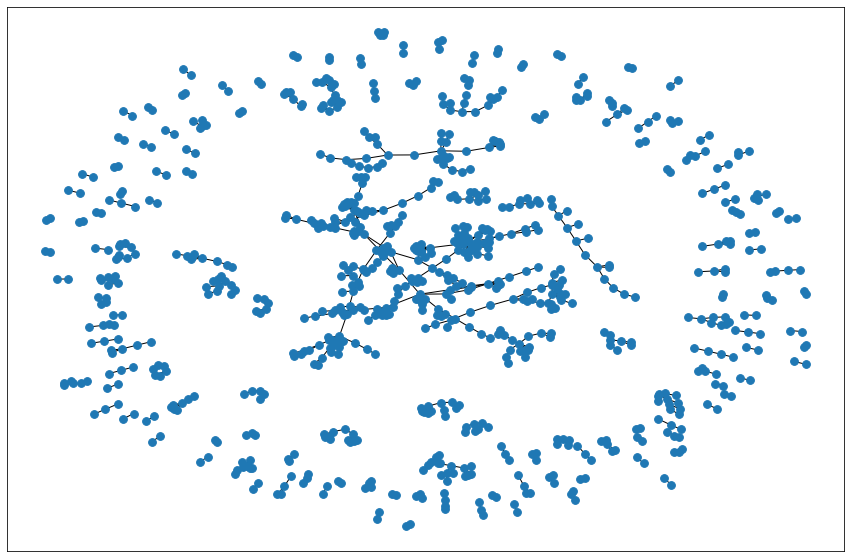

In [140]:
#S = G.subgraph(sus_nodes)
S = nx.Graph()

for n in sus_nodes:
    S.add_node(n, bipartite=0, data=True)
    
for e in sus_edge:
    #print(e)
    S.add_node(e[1], bipartite=1, data=True)

S.add_edges_from(sus_edge)
#print(sus_edge)
print(len(S.nodes()))
Scc = sorted(nx.connected_components(S), key=len, reverse=True)
# selecting the biggest component
print(len(Scc[2]))
S0 = S.subgraph(Scc[2])
print('Scc length', len(Scc))

p_nodes_scc = {n for n, d in S0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_scc = set(S0) - p_nodes_scc

print(len(p_nodes_scc), len(c_nodes_scc))

plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(S, seed=23)

nx.draw_networkx(S, pos, node_size=60, with_labels=False)

Sp 14 21


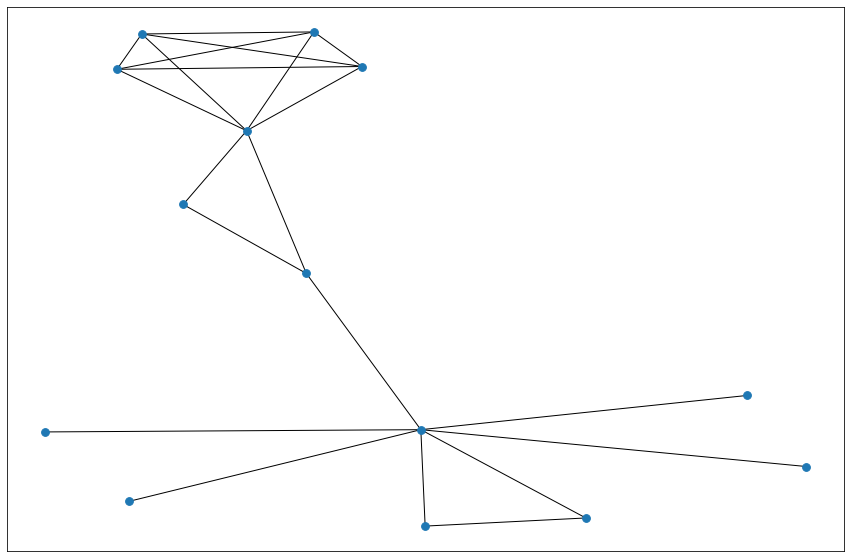

In [141]:
# project onto crimes and visualise
Sp = bipartite.weighted_projected_graph(S0, p_nodes_scc)

print('Sp',len(Sp.nodes()), len(Sp.edges()))

#Suspects only largest connected component
plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(Sp, seed=23)

nx.draw_networkx(Sp, pos, node_size=60, with_labels=False)

In [142]:
communities_sp = sorted(comms.greedy_modularity_communities(Sp), key=len, reverse=True) #17 coms modularity 0.770
#communities_sp = sorted(comms.label_propagation_communities(Sp), key=len, reverse=True) #54 coms modularity 0.745

# Count the communities
print(f"There are {len(communities_sp)} communities.")


for i in range(len(communities_sp)):
    if POI in communities_sp[i]:
        print(f'The POI ({POI}) is in community {i}')
        highlight = i #sets the POI's community to be highlighted in graphs below
        
Sp.nodes

There are 2 communities.
The POI (p815) is in community 0


NodeView(('p664', 'p192', 'p663', 'p740', 'p411', 'p367', 'p465', 'p283', 'p441', 'p815', 'p333', 'p592', 'p705', 'p739'))

0 7
1 7


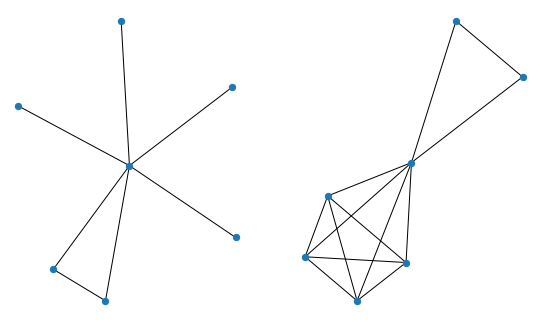

In [143]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,2): 
    com = Sp.subgraph(communities_sp[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/1-10_Sp_community.jpg')

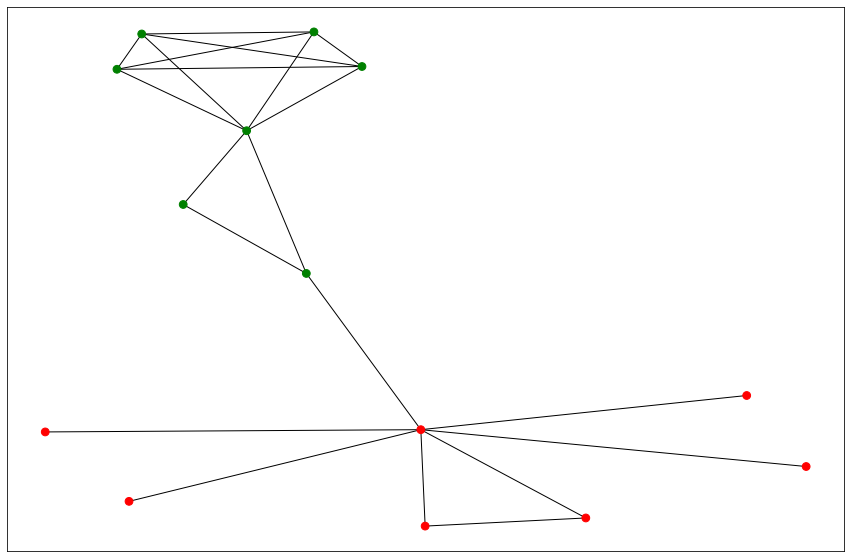

In [144]:
highlight = 0 #choose a community to highlight via it's index in the communities list

node_col = []

for node in Sp.nodes():
    if node in communities_sp[0]:
        node_col.append('red')
    elif node in communities_sp[1]:
        node_col.append('green')
    elif node in communities_sp[2]:
        node_col.append('purple')
    elif node in communities_sp[3]:
        node_col.append('aqua')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(Sp, seed=23)

nx.draw_networkx(Sp, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_people_projection.jpg')

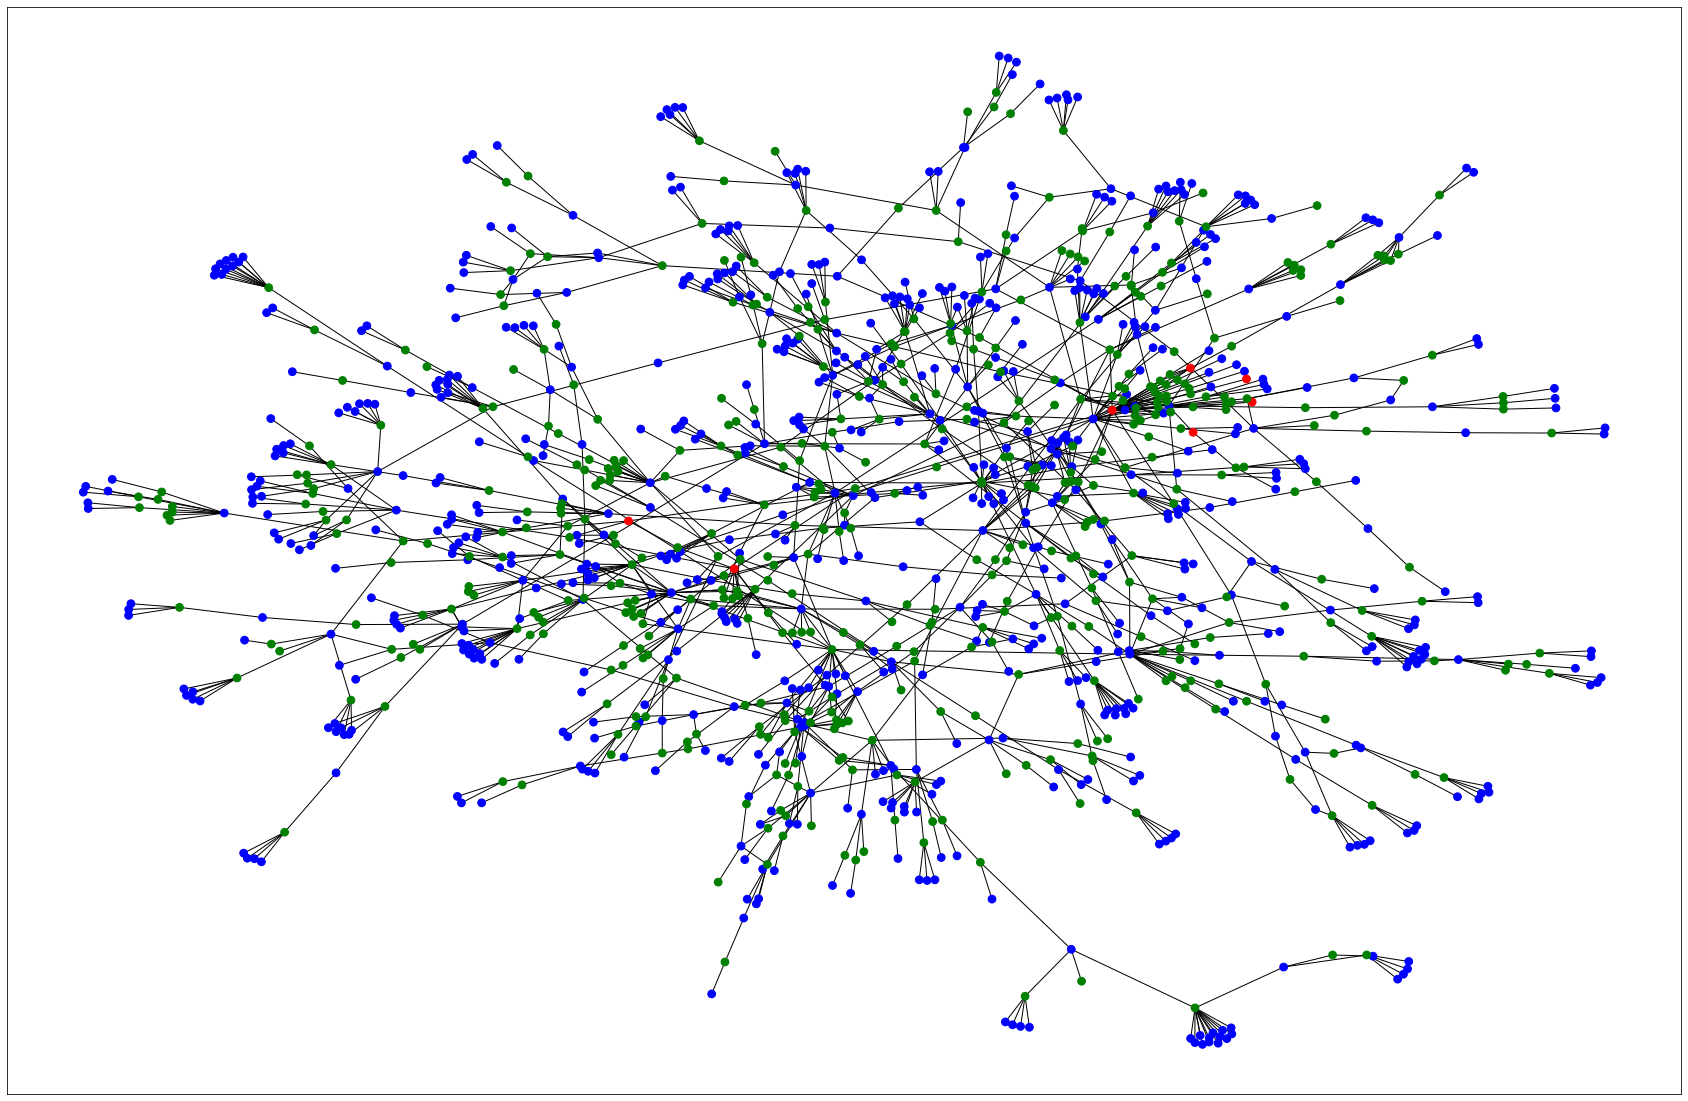

In [145]:
node_col = []

for node in G0.nodes():
    if node in communities_sp[highlight]:
        node_col.append('red')
    elif node in c_nodes_gcc:
        node_col.append('green')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_lcc_no projection.jpg')

In [146]:
ed = []
lab = {}

for per in communities_sp[highlight]:
    print('\n------\n\n',nx.get_node_attributes(G, 'name')[per], nx.get_node_attributes(G, 'sex')[per])
    lab[per] = (nx.get_node_attributes(G, 'name')[per], per)
    for c in G.edges([per]):
        if nx.get_edge_attributes(G0, 'role')[c] == 'Suspect':
            print(c, nx.get_edge_attributes(G0, 'role')[c])
            ed.append(c[1])
            lab[c[1]] = f'{c[1]}'
        
for i in communities_sp[highlight]:
    ed.append(i)


------

 QuincyMike 1
('p664', '513') Suspect

------

 QuillGraham 1
('p663', '400') Suspect
('p663', '511') Suspect
('p663', '512') Suspect

------

 WesterlyKevin 1
('p815', '185') Suspect
('p815', '352') Suspect
('p815', '404') Suspect
('p815', '415') Suspect
('p815', '473') Suspect
('p815', '512') Suspect
('p815', '513') Suspect
('p815', '525') Suspect
('p815', '529') Suspect
('p815', '547') Suspect
('p815', '548') Suspect
('p815', '549') Suspect

------

 HopkinsSylvia 0
('p441', '185') Suspect
('p441', '433') Suspect

------

 FindlayGary 1
('p333', '351') Suspect
('p333', '352') Suspect

------

 MullinsMarv 1
('p592', '351') Suspect
('p592', '352') Suspect
('p592', '353') Suspect
('p592', '495') Suspect

------

 ShermanAmos 1
('p705', '529') Suspect


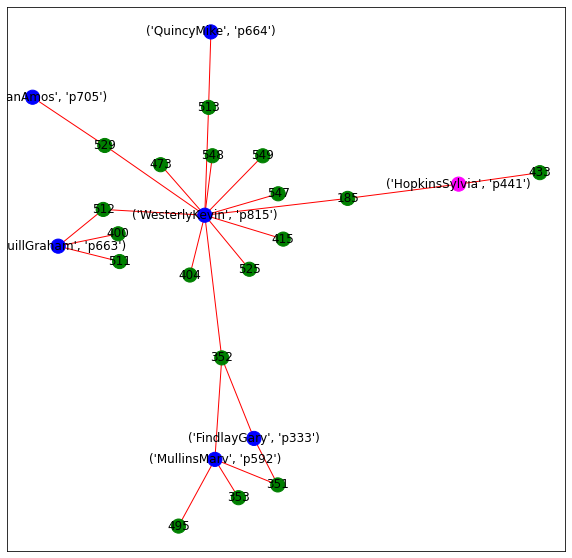

In [147]:
nc = []
ec = []

hi = G.subgraph(ed)

for node in hi:
    if node in communities_sp[highlight]:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('blue')
        else:
            nc.append('magenta')
    elif node in c_nodes_gcc:
        nc.append('green')
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
for edge in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[edge]
    if a == 'Victim':
        ec.append('white')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('white')
    else:
        ec.append('white')
        
        

plt.rcParams.update({'figure.figsize': (10, 10)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

#plt.savefig(f'../Figures/community_{highlight}_focus_labelled.jpg')

In [85]:
for c in communities_sp:
    peeps = []
    for p in c:
        peeps.append(nx.get_node_attributes(G, 'last')[p])
    print(len(c), len(peeps), len(set(peeps)))


11 11 11
11 11 11
9 9 9
7 7 7
7 7 7
